<a href="https://colab.research.google.com/github/snoop2head/study_in_yellow/blob/master/bee_vs_wasp_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference: https://www.kaggle.com/koshirosato/bee-or-wasp-base-line-using-resnet50

In [1]:
import os
import gc
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tqdm import tqdm

print('TensorFlow version: %s' % tf.__version__)


TensorFlow version: 2.3.0


In [2]:
!git clone https://github.com/snoop2head/study_in_yellow

Cloning into 'study_in_yellow'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 17859 (delta 8), reused 12 (delta 3), pack-reused 17830
Receiving objects: 100% (17859/17859), 681.22 MiB | 31.94 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Checking out files: 100% (17969/17969), done.


In [3]:
ROOT = './study_in_yellow/kaggle_bee_vs_wasp/'
SEED = 42
EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 256


df = pd.read_csv(ROOT+'labels.csv')
df.head()

id                               path  ...  is_final_validation  label
0   1  bee1\10007154554_026417cfd0_n.jpg  ...                    0    bee
1   2  bee1\10024864894_6dc54d4b34_n.jpg  ...                    1    bee
2   3  bee1\10092043833_7306dfd1f0_n.jpg  ...                    0    bee
3   4   bee1\1011948979_fc3637e779_w.jpg  ...                    1    bee
4   5  bee1\10128235063_dca17db76c_n.jpg  ...                    0    bee

[5 rows x 10 columns]

In [4]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

In [5]:
for idx in tqdm(df.index):    
    df.loc[idx,'path']=df.loc[idx,'path'].replace('\\', '/') 
    
df.head()

100%|██████████| 11421/11421 [00:09<00:00, 1157.51it/s]


id                               path  ...  is_final_validation  label
0   1  bee1/10007154554_026417cfd0_n.jpg  ...                    0    bee
1   2  bee1/10024864894_6dc54d4b34_n.jpg  ...                    1    bee
2   3  bee1/10092043833_7306dfd1f0_n.jpg  ...                    0    bee
3   4   bee1/1011948979_fc3637e779_w.jpg  ...                    1    bee
4   5  bee1/10128235063_dca17db76c_n.jpg  ...                    0    bee

[5 rows x 10 columns]

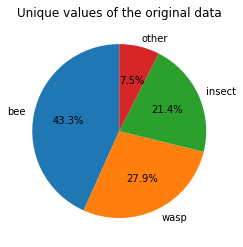

In [6]:
labels = list(df['label'].unique())
y = list(df['label'].value_counts())
plt.pie(y, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Unique values of the original data')
plt.show()

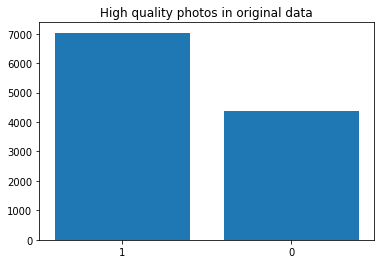

In [7]:
labels = list(df['photo_quality'].unique())
x = range(0, 2)
y = list(df['photo_quality'].value_counts())
plt.bar(x, y, tick_label=labels)
plt.title('High quality photos in original data')

plt.show()

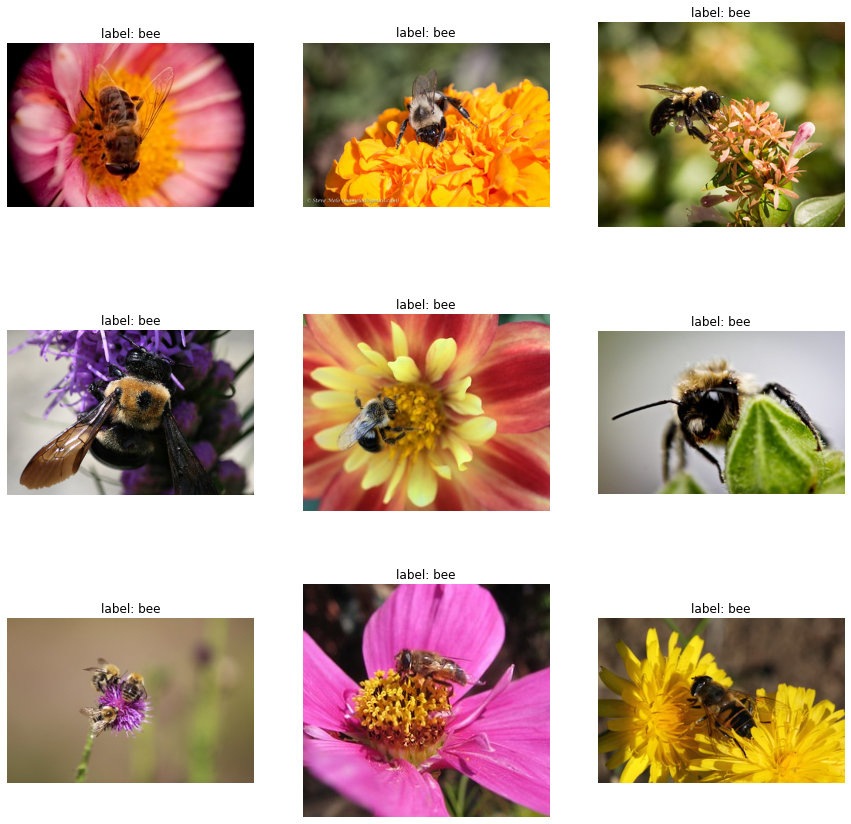

In [8]:
def img_plot(df, label):
    df = df.query('label == @label')
    imgs = []
    for path in df['path'][:9]:
        img = cv2.imread(ROOT+path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
    f, ax = plt.subplots(3, 3, figsize=(15,15))
    for i, img in enumerate(imgs):
        ax[i//3, i%3].imshow(img)
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('label: %s' % label)
    plt.show()
    
    
img_plot(df, label='bee')


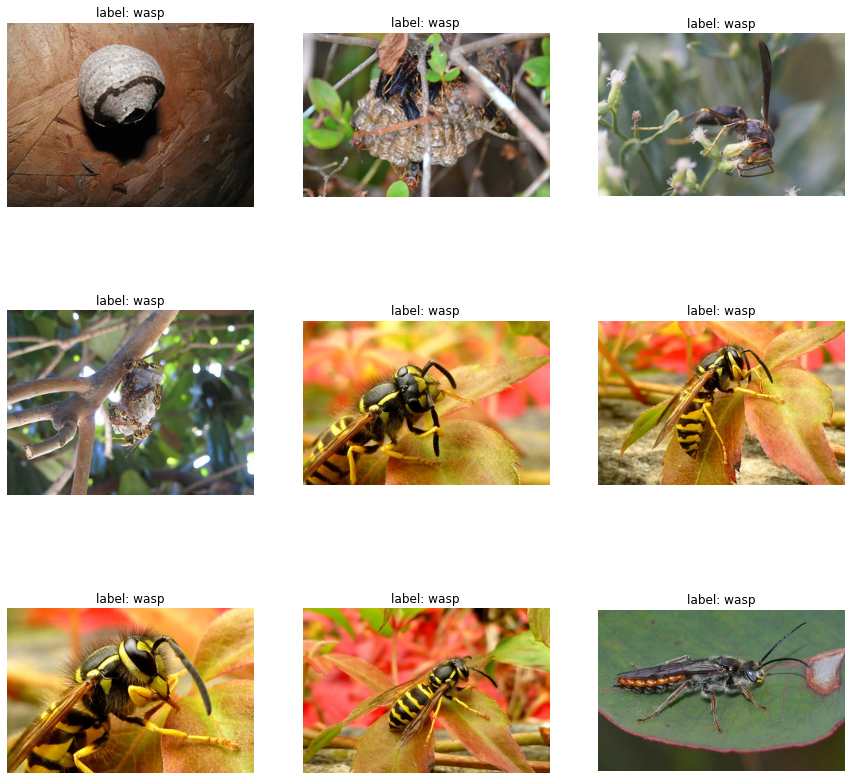

In [9]:
img_plot(df, label='wasp')


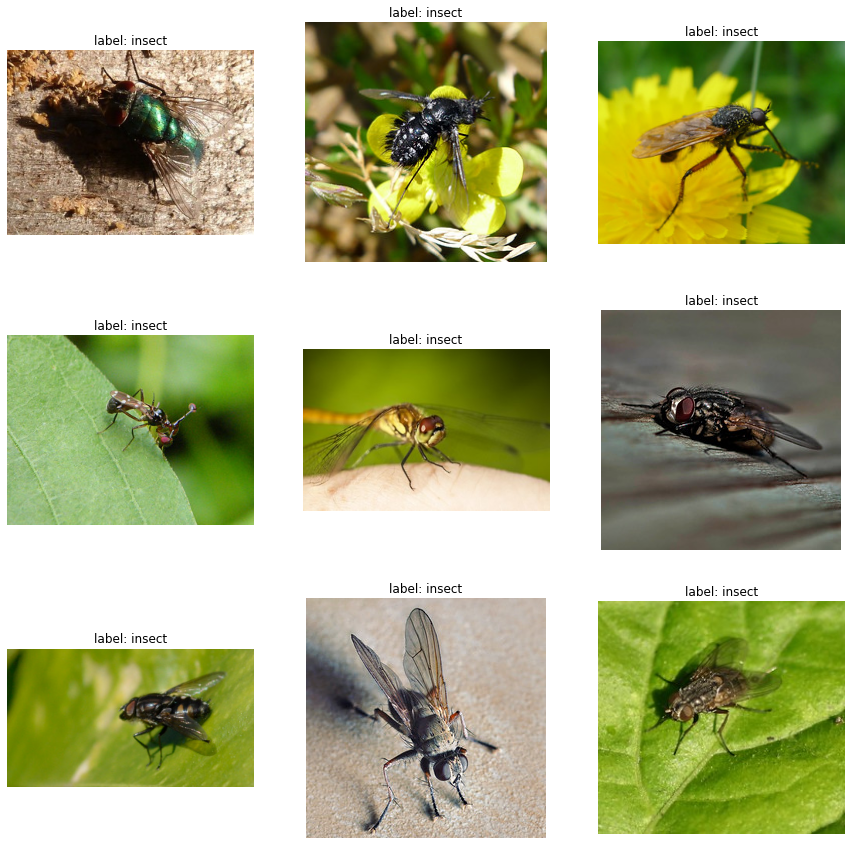

In [10]:
img_plot(df, label='insect')

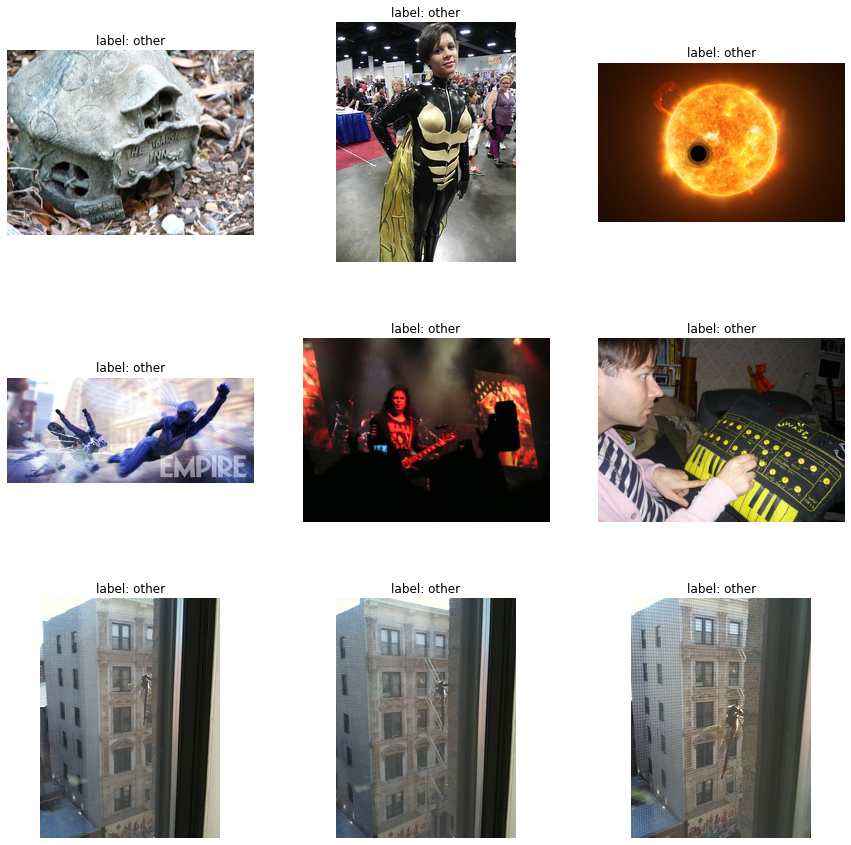

In [11]:
img_plot(df, label='other')

In [12]:
# select only high quality photos
df = df.query('photo_quality == 1')
df['label'].value_counts()

bee       2469
insect    2439
wasp      2127
Name: label, dtype: int64

In [13]:
train_df = df.query('is_validation == 0 & is_final_validation == 0').reset_index(drop=True)
val_df = df.query('is_validation == 1').reset_index(drop=True)
test_df = df.query('is_final_validation == 1').reset_index(drop=True)

In [14]:
def create_datasets(df, img_size):
    imgs = []
    for path in tqdm(df['path']):
        img = cv2.imread(ROOT+path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size,img_size))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    imgs = imgs / 255.0
    df = pd.get_dummies(df['label'])
    return imgs, df


train_imgs, train_df = create_datasets(train_df, IMG_SIZE)
val_imgs, val_df = create_datasets(val_df, IMG_SIZE)
test_imgs, test_df = create_datasets(test_df, IMG_SIZE)

100%|██████████| 1084/1084 [00:02<00:00, 535.78it/s]


In [15]:
def build_model(img_size, n):
    inp = Input(shape=(img_size,img_size,n))
    resnet = tf.keras.applications.ResNet50(input_shape=(img_size,img_size,n), 
                                            weights='imagenet', 
                                            include_top=False)
    x = resnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(3, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x) 
    opt = tf.keras.optimizers.SGD(momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model(IMG_SIZE, 3)
model.summary()

94773248/94765736 [==============================] - 2s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________


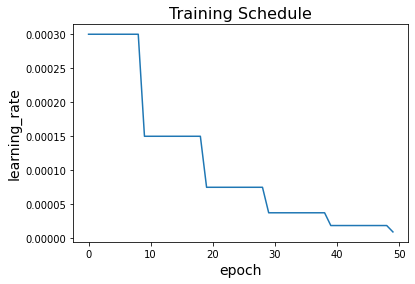

In [16]:
def get_lr_callback(batch_size=32, plot=False):
    start_lr = 3e-4
    def step_decay(epoch):
        drop = 0.5
        epochs_drop = 10.0
        lr = start_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        return lr
    
    lr_callback = tf.keras.callbacks.LearningRateScheduler(step_decay)
    if plot == True:
        rng = [i for i in range(EPOCHS)]
        y = [step_decay(x) for x in rng]
        plt.plot(rng, y)
        plt.xlabel('epoch', size=14)
        plt.ylabel('learning_rate', size=14)
        plt.title('Training Schedule', size=16)
        plt.show()
        
    return lr_callback


get_lr_callback(plot=True)


Epoch 1/50
154/154 [==============================] - 36s 235ms/step - loss: 0.6187 - accuracy: 0.7423 - val_loss: 1.4497 - val_accuracy: 0.3423
Epoch 2/50
154/154 [==============================] - 34s 224ms/step - loss: 0.2794 - accuracy: 0.9012 - val_loss: 2.0028 - val_accuracy: 0.3423
Epoch 3/50
154/154 [==============================] - 34s 223ms/step - loss: 0.1865 - accuracy: 0.9374 - val_loss: 1.7594 - val_accuracy: 0.3768
Epoch 4/50
154/154 [==============================] - 35s 224ms/step - loss: 0.1339 - accuracy: 0.9552 - val_loss: 1.1677 - val_accuracy: 0.5014
Epoch 5/50
154/154 [==============================] - 35s 224ms/step - loss: 0.0920 - accuracy: 0.9698 - val_loss: 0.8440 - val_accuracy: 0.6846
Epoch 6/50
154/154 [==============================] - 35s 224ms/step - loss: 0.0738 - accuracy: 0.9756 - val_loss: 0.4508 - val_accuracy: 0.8428
Epoch 7/50
154/154 [==============================] - 35s 224ms/step - loss: 0.0525 - accuracy: 0.9839 - val_loss: 0.3058 - val_ac

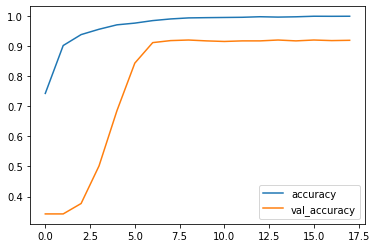

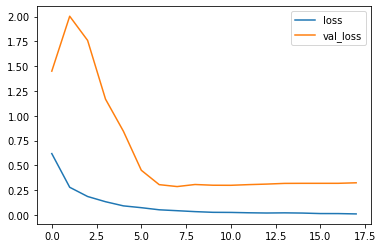

7451

In [17]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, 
                                               verbose=1, 
                                               restore_best_weights=True)

history = model.fit(train_imgs, 
                    train_df, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=[es_callback, get_lr_callback(BATCH_SIZE)], 
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

gc.collect()


In [18]:
model.evaluate(test_imgs, test_df) 

34/34 [==============================] - 3s 75ms/step - loss: 0.2596 - accuracy: 0.9197


[0.25961893796920776, 0.919741690158844]

In [23]:
from tensorflow.keras.preprocessing import image as img

def testing_image(image_directory): #testing out our model
    test_image = img.load_img(image_directory, target_size = (150, 150))
    test_image = img.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = model.predict(x = test_image)
    print(result)
    if result[0][2]==max(result[0]):
        print('Other than insects')
    elif result[0][1]==max(result[0]):
        print('Insects')
    elif result[0][0]==max(result[0]):
        print('Bees')
    else:
        print('wasps')


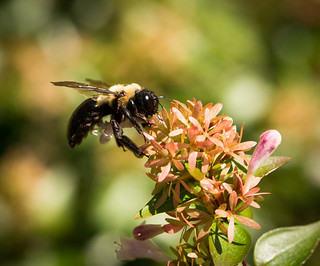

In [24]:
from IPython.display import Image
Image(f"{ROOT}/bee1/10092043833_7306dfd1f0_n.jpg")

In [25]:
testing_image(f'{ROOT}/bee1/10092043833_7306dfd1f0_n.jpg')

[[0. 0. 1.]]
Other than insects


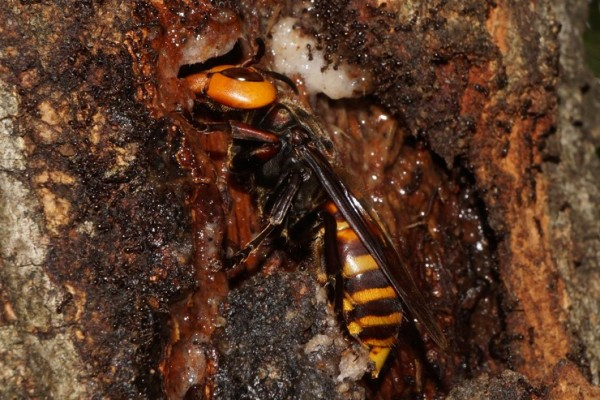

In [27]:
KILLER_ROOT = './study_in_yellow/asian-giant-hornet'
Image(f'{KILLER_ROOT}/naver_0005.jpg')

In [28]:
testing_image(f'{KILLER_ROOT}/naver_0003.jpg')

[[0. 0. 1.]]
Other than insects
